## 1. Configuração Inicial

In [1]:
# Importar bibliotecas
import sys
import warnings
warnings.filterwarnings('ignore')

# Adicionar src ao path
sys.path.append('../src')

# Importar módulos do sistema
from genetic_algorithm import GeneticAlgorithm
from routing import RouteOptimizer, create_sample_data, Priority
from visualization import RouteVisualizer
from llm_integration import LLMReportGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configurar visualização
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Configuração concluída!")
print("Todos os módulos importados com sucesso!")

Configuração concluída!
Todos os módulos importados com sucesso!


## 2. Carregar Dados de Entrega

In [2]:
# Criar dados de exemplo
delivery_points, vehicles = create_sample_data()

print(f"Pontos de Entrega: {len(delivery_points)}")
print(f"Veículos Disponíveis: {len(vehicles)}")
print("="*70)

# Mostrar pontos de entrega
print("\nPONTOS DE ENTREGA:")
print("-" * 70)
for point in delivery_points:
    if point.id == 0:
        print(f"  {point.id:2d}. {point.name:40s} [DEPÓSITO]")
    else:
        meds_info = f" ({len(point.medications)} itens)" if point.medications else ""
        print(f"  {point.id:2d}. {point.name:40s} [{point.priority.name:8s}] {point.demand:5.1f}kg{meds_info}")

# Mostrar exemplo de medicamentos em um ponto
if len(delivery_points) > 1 and delivery_points[1].medications:
    print(f"\nEXEMPLO - Medicamentos para {delivery_points[1].name}:")
    print("-" * 70)
    for med in delivery_points[1].medications:
        print(f"  • {med.name:30s} [{med.type:12s}] {med.quantity:5.1f} un - {med.total_weight:5.1f}kg")

print("\nVEÍCULOS:")
print("-" * 70)
for vehicle in vehicles:
    print(f"  {vehicle.name:15s} - Capacidade: {vehicle.capacity}kg, Autonomia: {vehicle.max_distance}km")


Pontos de Entrega: 31
Veículos Disponíveis: 3

PONTOS DE ENTREGA:
----------------------------------------------------------------------
   0. Hospital Central (Depósito)              [DEPÓSITO]
   1. UBS Vila Mariana                         [HIGH    ]  30.5kg (5 itens)
   2. UBS Mooca                                [CRITICAL]   4.6kg (2 itens)
   3. UBS Pinheiros                            [CRITICAL]  25.0kg (3 itens)
   4. UBS Tatuapé                              [CRITICAL]  36.5kg (5 itens)
   5. Atendimento Domiciliar Sr. Silva         [CRITICAL]  30.7kg (5 itens)
   6. Atendimento Domiciliar Sra. Santos       [HIGH    ]  10.7kg (2 itens)
   7. UBS Ipiranga                             [CRITICAL]  14.5kg (3 itens)
   8. UBS Santana                              [CRITICAL]   7.8kg (2 itens)
   9. Clínica Butantã                          [CRITICAL]  12.4kg (3 itens)
  10. Atendimento Domiciliar Sr. Oliveira      [HIGH    ]  27.8kg (5 itens)
  11. UBS Consolação                         

## 3. Inicializar Otimizador

In [3]:
# Criar otimizador de rotas
optimizer = RouteOptimizer(
    delivery_points=delivery_points,
    vehicles=vehicles,
    depot_id=0
)

print("Otimizador criado!")
print(f"Matriz de distâncias: {optimizer.distance_matrix.shape}")
print(f"Função fitness configurada com {len(optimizer.weights)} restrições")

# Mostrar matriz de distâncias (primeiros pontos)
print("\nMatriz de Distâncias (km) - Primeiros 5 pontos:")
dist_df = pd.DataFrame(
    optimizer.distance_matrix[:5, :5],
    columns=[p.name[:20] for p in delivery_points[:5]],
    index=[p.name[:20] for p in delivery_points[:5]]
)
print(dist_df.round(2))

Otimizador criado!
Matriz de distâncias: (31, 31)
Função fitness configurada com 5 restrições

Matriz de Distâncias (km) - Primeiros 5 pontos:
                      Hospital Central (De  UBS Vila Mariana  UBS Mooca  \
Hospital Central (De                  0.00              4.19       3.90   
UBS Vila Mariana                      4.19              0.00       6.08   
UBS Mooca                             3.90              6.08       0.00   
UBS Pinheiros                         5.18              5.21       8.99   
UBS Tatuapé                           6.05              8.33       2.32   

                      UBS Pinheiros  UBS Tatuapé  
Hospital Central (De           5.18         6.05  
UBS Vila Mariana               5.21         8.33  
UBS Mooca                      8.99         2.32  
UBS Pinheiros                  0.00        11.21  
UBS Tatuapé                   11.21         0.00  


## 4. Configurar e Executar Algoritmo Genético

Configuração dos parâmetros do AG e execução da otimização.

In [4]:
# Configurar Algoritmo Genético
ga = GeneticAlgorithm(
    population_size=100,      # Número de soluções por geração
    generations=300,          # Número de iterações
    mutation_rate=0.2,        # 20% de chance de mutação
    crossover_rate=0.8,       # 80% de chance de crossover
    elite_size=5,             # Preservar 5 melhores
    tournament_size=5,        # Torneio com 5 indivíduos
    random_seed=42            # Reprodutibilidade
)

print("Algoritmo Genético Configurado!")
print("="*70)
print(f"  População: {ga.population_size} indivíduos")
print(f"  Gerações: {ga.generations}")
print(f"  Taxa de Mutação: {ga.mutation_rate*100}%")
print("="*70)

# Executar otimização
print("\nExecutando otimização...")
print("Aguarde enquanto o AG busca a melhor solução...")

# Definir função fitness (usa o método fitness_function do otimizador)
def fitness_function(route):
    return optimizer.fitness_function(route, vehicle_id=0)

# Executar evolução
best_solution = ga.evolve(
    num_points=len(delivery_points),
    fitness_function=fitness_function,
    depot=0,
    verbose=True
)

print("\nOtimização concluída!")
print(f"Melhor fitness encontrado: {best_solution.fitness:.2f}")


Algoritmo Genético Configurado!
  População: 100 indivíduos
  Gerações: 300
  Taxa de Mutação: 20.0%

Executando otimização...
Aguarde enquanto o AG busca a melhor solução...


Evolução do AG: 100%|██████████| 300/300 [00:01<00:00, 250.92it/s, Melhor=345661.47, Média=345964.00]


Otimização concluída!
Melhor fitness encontrado: 345661.47


## 5. Analisar Resultados

In [5]:
# Obter estatísticas
stats = ga.get_statistics()

print("="*70)
print("ESTATÍSTICAS DA OTIMIZAÇÃO")
print("="*70)
print(f"  Fitness Inicial: {stats['best_fitness_initial']:.2f}")
print(f"  Fitness Final:   {stats['best_fitness_final']:.2f}")
print(f"  Melhoria:        {stats['improvement']:.2f} ({stats['improvement_percentage']:.1f}%)")
print(f"  Gerações:        {stats['generations']}")
print("="*70)

# Obter informações da melhor rota
route_info = optimizer.get_route_info(best_solution.genes, vehicle_id=0)

print("\nMELHOR ROTA ENCONTRADA")
print("="*70)
print(f"  Veículo:             {route_info['vehicle']}")
print(f"  Distância Total:     {route_info['distance_km']} km")
print(f"  Tempo de Viagem:     {route_info['travel_time_hours']:.1f} horas")
print(f"  Tempo de Serviço:    {route_info['service_time_hours']:.1f} horas")
print(f"  Tempo Total:         {route_info['total_time_hours']:.1f} horas")
print(f"  Custo Estimado:      R$ {route_info['cost_reais']:.2f}")
print(f"  Número de Entregas:  {route_info['num_deliveries']}")
print(f"  Uso de Capacidade:   {route_info['capacity_usage_percent']:.1f}%")
print(f"  Uso de Autonomia:    {route_info['autonomy_usage_percent']:.1f}%")
print("="*70)

# Mostrar sequência da rota
print("\nSEQUÊNCIA DA ROTA:")
print("-" * 70)
for i, point_id in enumerate(best_solution.genes):
    point = delivery_points[point_id]
    if i == 0:
        print(f"  START → {point.name} (DEPÓSITO)")
    elif i == len(best_solution.genes) - 1:
        print(f"  END   → {point.name} (DEPÓSITO)")
    else:
        print(f"  {i:2d}.    → {point.name:40s} [{point.priority.name:8s}] {point.demand}kg")

ESTATÍSTICAS DA OTIMIZAÇÃO
  Fitness Inicial: 375921.41
  Fitness Final:   345661.47
  Melhoria:        30259.94 (8.0%)
  Gerações:        300

MELHOR ROTA ENCONTRADA
  Veículo:             Van 001
  Distância Total:     107.28 km
  Tempo de Viagem:     3.1 horas
  Tempo de Serviço:    10.0 horas
  Tempo Total:         13.1 horas
  Custo Estimado:      R$ 268.21
  Número de Entregas:  30
  Uso de Capacidade:   1463.6%
  Uso de Autonomia:    89.4%

SEQUÊNCIA DA ROTA:
----------------------------------------------------------------------
  START → Hospital Central (Depósito) (DEPÓSITO)
   1.    → Clínica Higienópolis                     [CRITICAL] 27.204444037397653kg
   2.    → UBS Consolação                           [CRITICAL] 39.915540978278685kg
   3.    → UBS Pinheiros                            [CRITICAL] 25.00699944173915kg
   4.    → Atendimento Domiciliar Sr. Silva         [CRITICAL] 30.686460850384158kg
   5.    → Hospital São Paulo                       [CRITICAL] 17.27859088

## 6. Visualizar Evolução do Algoritmo

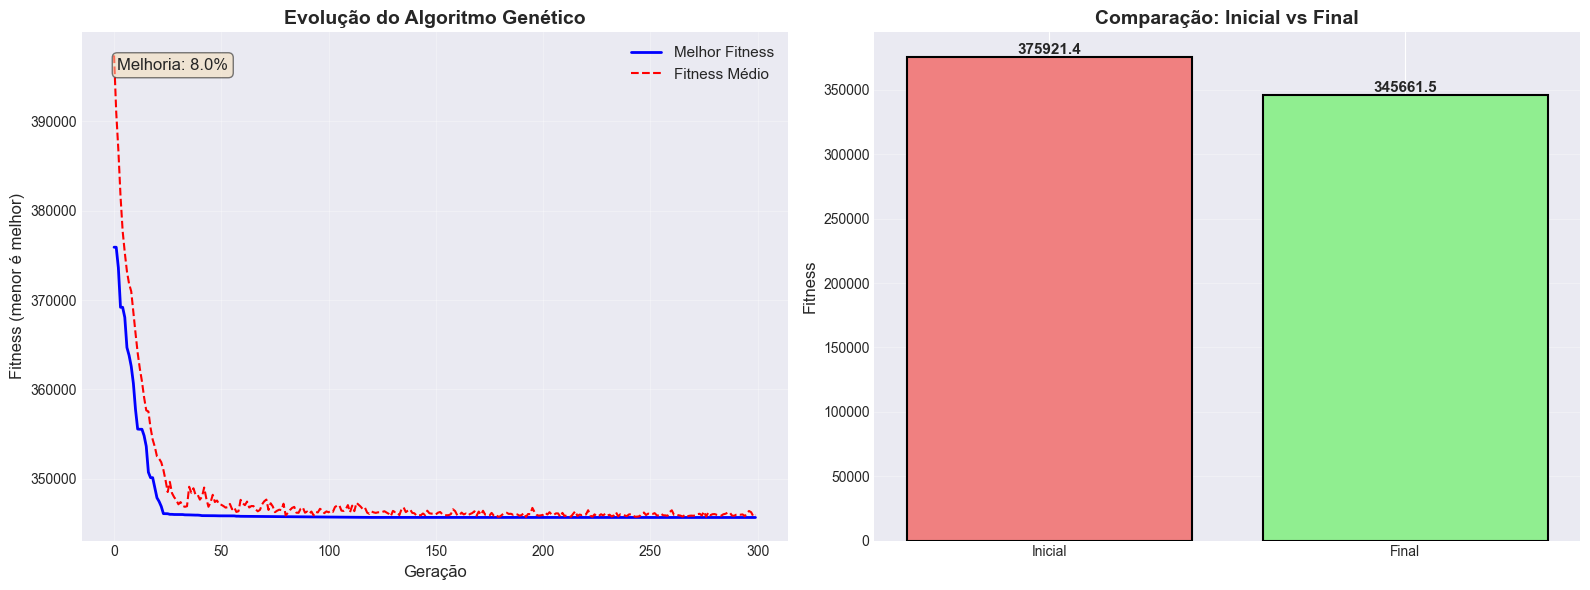

In [7]:
# Plotar evolução
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Fitness ao longo das gerações
generations = range(len(ga.best_fitness_history))
ax1.plot(generations, ga.best_fitness_history, 'b-', linewidth=2, label='Melhor Fitness')
ax1.plot(generations, ga.avg_fitness_history, 'r--', linewidth=1.5, label='Fitness Médio')
ax1.set_xlabel('Geração', fontsize=12)
ax1.set_ylabel('Fitness (menor é melhor)', fontsize=12)
ax1.set_title('Evolução do Algoritmo Genético', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Adicionar anotação
improvement_pct = stats['improvement_percentage']
ax1.text(0.05, 0.95, f'Melhoria: {improvement_pct:.1f}%', 
         transform=ax1.transAxes, fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Gráfico 2: Histograma de fitness final
final_population_fitness = [fitness_function(ind.genes)[0] for ind in ga.evolve.__self__.best_individual.__class__.__new__(ga.evolve.__self__.best_individual.__class__).__dict__.get('population', [best_solution])]
# Simplificado: apenas mostrar o melhor
ax2.bar(['Inicial', 'Final'], [stats['best_fitness_initial'], stats['best_fitness_final']], 
        color=['lightcoral', 'lightgreen'], edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Fitness', fontsize=12)
ax2.set_title('Comparação: Inicial vs Final', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, v in enumerate([stats['best_fitness_initial'], stats['best_fitness_final']]):
    ax2.text(i, v + 20, f'{v:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## 7. Criar Mapa Interativo

In [8]:
# Criar visualizador
visualizer = RouteVisualizer(delivery_points, output_dir='../results/graficos')

# Verificar se precisa dividir em múltiplas rotas
if route_info['capacity_usage_percent'] > 100 or route_info['autonomy_usage_percent'] > 100:
    print("AVISO: Rota única excede limites. Dividindo em múltiplas rotas...")
    routes = optimizer.split_route_for_multiple_vehicles(best_solution.genes)
    route_infos = [optimizer.get_route_info(r, i % len(vehicles)) for i, r in enumerate(routes)]
    print(f"Dividido em {len(routes)} rotas")
else:
    print("Rota única é viável!")
    routes = [best_solution.genes]
    route_infos = [route_info]

# Criar mapa
print("\nGerando mapa interativo...")
mapa = visualizer.create_route_map(
    routes,
    route_infos,
    filename="mapa_rotas_notebook.html"
)

print("Mapa gerado!")
print(f"Arquivo salvo em: results/graficos/mapa_rotas_notebook.html")

# Mostrar resumo das rotas
if len(routes) > 1:
    print(f"\nRESUMO DAS {len(routes)} ROTAS:")
    print("="*70)
    for i, info in enumerate(route_infos, 1):
        print(f"  Rota {i} ({info['vehicle']}):")
        print(f"    Distância: {info['distance_km']}km | Tempo: {info['total_time_hours']:.1f}h | Custo: R${info['cost_reais']:.2f}")
    print("="*70)


AVISO: Rota única excede limites. Dividindo em múltiplas rotas...
Dividido em 20 rotas

Gerando mapa interativo...
Mapa salvo em: ..\results\graficos\mapa_rotas_notebook.html
Mapa gerado!
Arquivo salvo em: results/graficos/mapa_rotas_notebook.html

RESUMO DAS 20 ROTAS:
  Rota 1 (Van 001):
    Distância: 5.33km | Tempo: 0.5h | Custo: R$13.33
  Rota 2 (Van 002):
    Distância: 5.61km | Tempo: 0.5h | Custo: R$14.02
  Rota 3 (Moto 001):
    Distância: 10.35km | Tempo: 0.5h | Custo: R$15.53
  Rota 4 (Van 001):
    Distância: 11.2km | Tempo: 1.2h | Custo: R$28.00
  Rota 5 (Van 002):
    Distância: 16.35km | Tempo: 1.0h | Custo: R$40.88
  Rota 6 (Moto 001):
    Distância: 13.35km | Tempo: 0.6h | Custo: R$20.03
  Rota 7 (Van 001):
    Distância: 19.35km | Tempo: 1.1h | Custo: R$48.38
  Rota 8 (Van 002):
    Distância: 24.71km | Tempo: 1.5h | Custo: R$61.77
  Rota 9 (Moto 001):
    Distância: 16.02km | Tempo: 0.9h | Custo: R$24.04
  Rota 10 (Van 001):
    Distância: 18.71km | Tempo: 0.9h | Cust

## 8. Criar Visualizações Adicionais

In [9]:
# Gráfico de evolução
print("Gerando gráfico de evolução...")
visualizer.plot_evolution(
    ga.best_fitness_history,
    ga.avg_fitness_history,
    filename="evolucao_notebook.png"
)

# Se múltiplas rotas, criar comparação
if len(routes) > 1:
    print("Gerando gráfico comparativo...")
    visualizer.plot_route_comparison(route_infos, filename="comparacao_notebook.png")
    visualizer.plot_capacity_usage(route_infos, filename="recursos_notebook.png")

# Dashboard interativo
print("Gerando dashboard interativo...")
visualizer.create_interactive_dashboard(route_infos, filename="dashboard_notebook.html")

print("\nTodas as visualizações foram geradas!")
print("Arquivos salvos em: results/graficos/")

Gerando gráfico de evolução...
Gráfico de evolução salvo em: ..\results\graficos\evolucao_notebook.png
Gerando gráfico comparativo...
Gráfico de comparação salvo em: ..\results\graficos\comparacao_notebook.png
Gráfico de uso de recursos salvo em: ..\results\graficos\recursos_notebook.png
Gerando dashboard interativo...
Dashboard interativo salvo em: ..\results\graficos\dashboard_notebook.html

Todas as visualizações foram geradas!
Arquivos salvos em: results/graficos/


## 9. Integração com LLM

Geração automática de relatórios e instruções utilizando Google Gemini (gratuito).
Requer configuração da variável de ambiente GEMINI_API_KEY.

Obtenha sua chave gratuita em: https://makersuite.google.com/app/apikey

In [10]:
# Inicializar gerador de relatórios
llm_generator = LLMReportGenerator()

print("Gerando relatórios com IA...\n")

# Instruções para motorista
for i, (route, info) in enumerate(zip(routes, route_infos), 1):
    print(f"Gerando instruções para Rota {i}...")
    instructions = llm_generator.generate_driver_instructions(
        route, info, delivery_points
    )
    llm_generator.save_report(
        instructions,
        f"instrucoes_rota_{i}_notebook.txt",
        output_dir="../results/relatorios"
    )

# Relatório executivo
print("Gerando relatório executivo...")
executive_report = llm_generator.generate_executive_report(
    route_infos,
    stats,
    delivery_points
)
llm_generator.save_report(
    executive_report,
    "relatorio_executivo_notebook.txt",
    output_dir="../results/relatorios"
)

# Sugestões de melhoria
print("Gerando sugestões de melhoria...")
improvements = llm_generator.suggest_improvements(route_infos)
llm_generator.save_report(
    improvements,
    "sugestoes_notebook.txt",
    output_dir="../results/relatorios"
)

print("\nRelatórios gerados!")
print("Arquivos salvos em: ../results/relatorios/")


Testando modelos Gemini disponíveis...
  Tentando gemini-2.5-flash-lite... ✓ Sucesso!

Gemini inicializado: gemini-2.5-flash-lite
Gerando relatórios com IA...

Gerando instruções para Rota 1...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_1_notebook.txt
Gerando instruções para Rota 2...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_2_notebook.txt
Gerando instruções para Rota 3...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_3_notebook.txt
Gerando instruções para Rota 4...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_4_notebook.txt
Gerando instruções para Rota 5...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_5_notebook.txt
Gerando instruções para Rota 6...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_6_notebook.txt
Gerando instruções para Rota 7...
Relatório salvo em: ..\results\relatorios\instrucoes_rota_7_notebook.txt
Gerando instruções para Rota 8...
Relatório salvo em: ..\results\relatorios\instrucoes_rota

## 10. Resumo Final

In [11]:
print("="*70)
print("OTIMIZAÇÃO CONCLUÍDA")
print("="*70)
print()
print("RESUMO DOS RESULTADOS:")
print("-" * 70)
print(f"  - Pontos de entrega processados: {len(delivery_points) - 1}")
print(f"  - Rotas otimizadas: {len(routes)}")
print(f"  - Melhoria alcançada: {stats['improvement_percentage']:.1f}%")
print(f"  - Distância total: {sum(r['distance_km'] for r in route_infos):.2f} km")
print(f"  - Custo total: R$ {sum(r['cost_reais'] for r in route_infos):.2f}")
print(f"  - Tempo total: {sum(r['total_time_hours'] for r in route_infos):.1f} horas")
print("-" * 70)
print()
print("ARQUIVOS GERADOS:")
print("-" * 70)
print("  Visualizações:")
print("    • results/graficos/mapa_rotas_notebook.html")
print("    • results/graficos/evolucao_notebook.png")
print("    • results/graficos/dashboard_notebook.html")
if len(routes) > 1:
    print("    • results/graficos/comparacao_notebook.png")
    print("    • results/graficos/recursos_notebook.png")
print()
print("  Relatórios:")
print("    • results/relatorios/instrucoes_rota_*_notebook.txt")
print("    • results/relatorios/relatorio_executivo_notebook.txt")
print("    • results/relatorios/sugestoes_notebook.txt")
print("="*70)


OTIMIZAÇÃO CONCLUÍDA

RESUMO DOS RESULTADOS:
----------------------------------------------------------------------
  - Pontos de entrega processados: 30
  - Rotas otimizadas: 20
  - Melhoria alcançada: 8.0%
  - Distância total: 261.58 km
  - Custo total: R$ 584.11
  - Tempo total: 17.0 horas
----------------------------------------------------------------------

ARQUIVOS GERADOS:
----------------------------------------------------------------------
  Visualizações:
    • results/graficos/mapa_rotas_notebook.html
    • results/graficos/evolucao_notebook.png
    • results/graficos/dashboard_notebook.html
    • results/graficos/comparacao_notebook.png
    • results/graficos/recursos_notebook.png

  Relatórios:
    • results/relatorios/instrucoes_rota_*_notebook.txt
    • results/relatorios/relatorio_executivo_notebook.txt
    • results/relatorios/sugestoes_notebook.txt


---

## Análises Adicionais

Possíveis extensões e análises:

1. **Visualizações**: Mapas interativos e dashboards disponíveis em `results/graficos/`
2. **Relatórios**: Documentos gerados pela IA em `results/relatorios/`
3. **Parâmetros**: Testes com diferentes configurações do AG
4. **Dados**: Adição de novos pontos de entrega ou veículos
5. **Restrições**: Inclusão de novas constraints no modelo



---

**Tech Challenge - Fase 2 | FIAP Pós-Tech IA para Devs**